# Define situation

In [51]:
import numpy as np

# set upper and lower bound for data values
upper_bound= 16.0
bounds = np.array([0.0, upper_bound])
# Set number of qubits used in the uncertainty model
# num_qubits = 4

num_dim = 1
num_discrete_values = 16
num_qubits = num_dim * int(np.log2(num_discrete_values))


# Define initial distribution to learn

[0.04573805 0.21432621 0.18068418 0.12398412 0.0956341  0.06293706
 0.05140805 0.04233604 0.03118503 0.03175203 0.02400302 0.02079002
 0.02173502 0.01795502 0.01682102 0.01871102]


<BarContainer object of 16 artists>

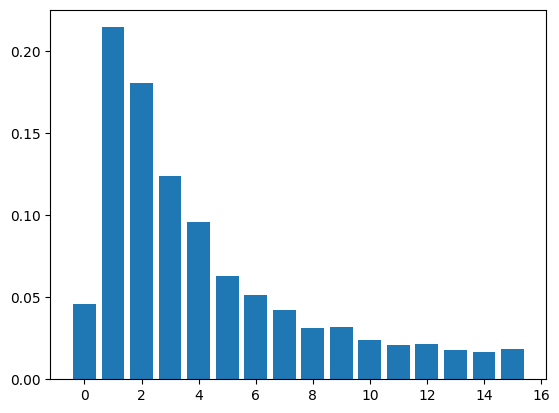

In [54]:
# Sample from target probability distribution
N = 10000 # number of samples to take

log_normal = np.random.lognormal(mean=1, sigma=1, size=int(N/2))
log_normal_2 = np.random.lognormal(mean=4, sigma=1, size=int(N/2))

# round to nearest integer
log_normal = np.round(log_normal)
log_normal_2 = np.round(log_normal_2)

# clip to range
log_normal = log_normal[log_normal <= upper_bound]
log_normal_2 = log_normal_2[log_normal_2 <= upper_bound]

log_normal_samples = []
for i in range(int(upper_bound)):
    log_normal_samples += [np.sum(log_normal == i) + np.sum(log_normal_2 == i)]

# normlize to get probability distribution
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))
print(log_normal_samples)

import matplotlib.pyplot as plt
plt.bar(np.arange(int(upper_bound)), log_normal_samples)

# Define qGAN

In [55]:
from qGAN import DistributionCircuitTrainer
trainer = DistributionCircuitTrainer(num_dim, num_discrete_values)

# setup the qGAN
trainer.define_init_distribution(init_dist = "uniform")
trainer.define_generator(ansatz="two-local", reps = 3)
trainer.define_discriminator(intermediate_layer_size=10)
trainer.define_loss()

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter
trainer.define_optimizer(lr, b1, b2)

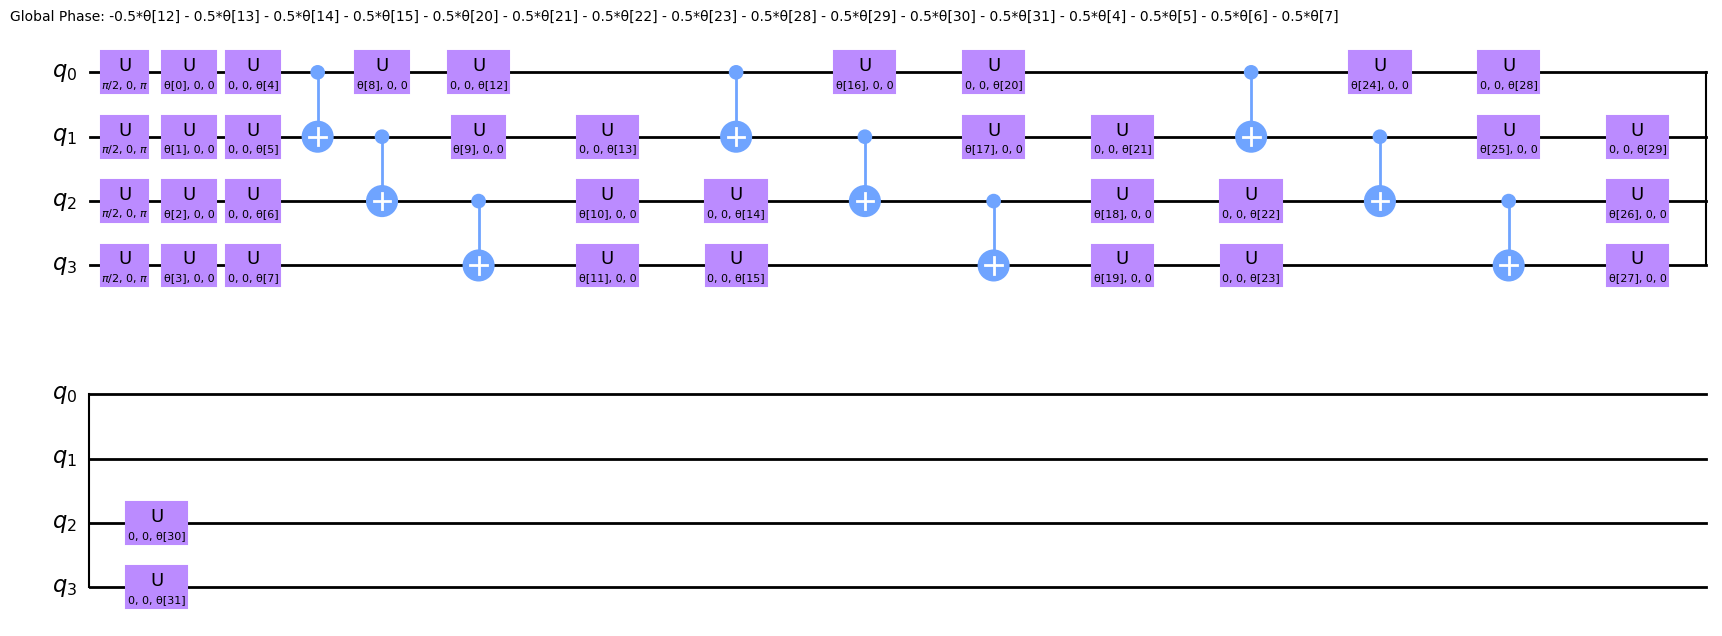

In [56]:
trainer.generator_creator.circuit.decompose(reps=4).draw(output='mpl')

In [57]:
print("# generator parameters: \t{}".format(trainer.num_generator_parameters))
print("# discriminator parameters: \t{}".format(trainer.num_discriminator_parameters))
# print(trainer.discriminator)

# generator parameters: 	32
# discriminator parameters: 	31


# Train

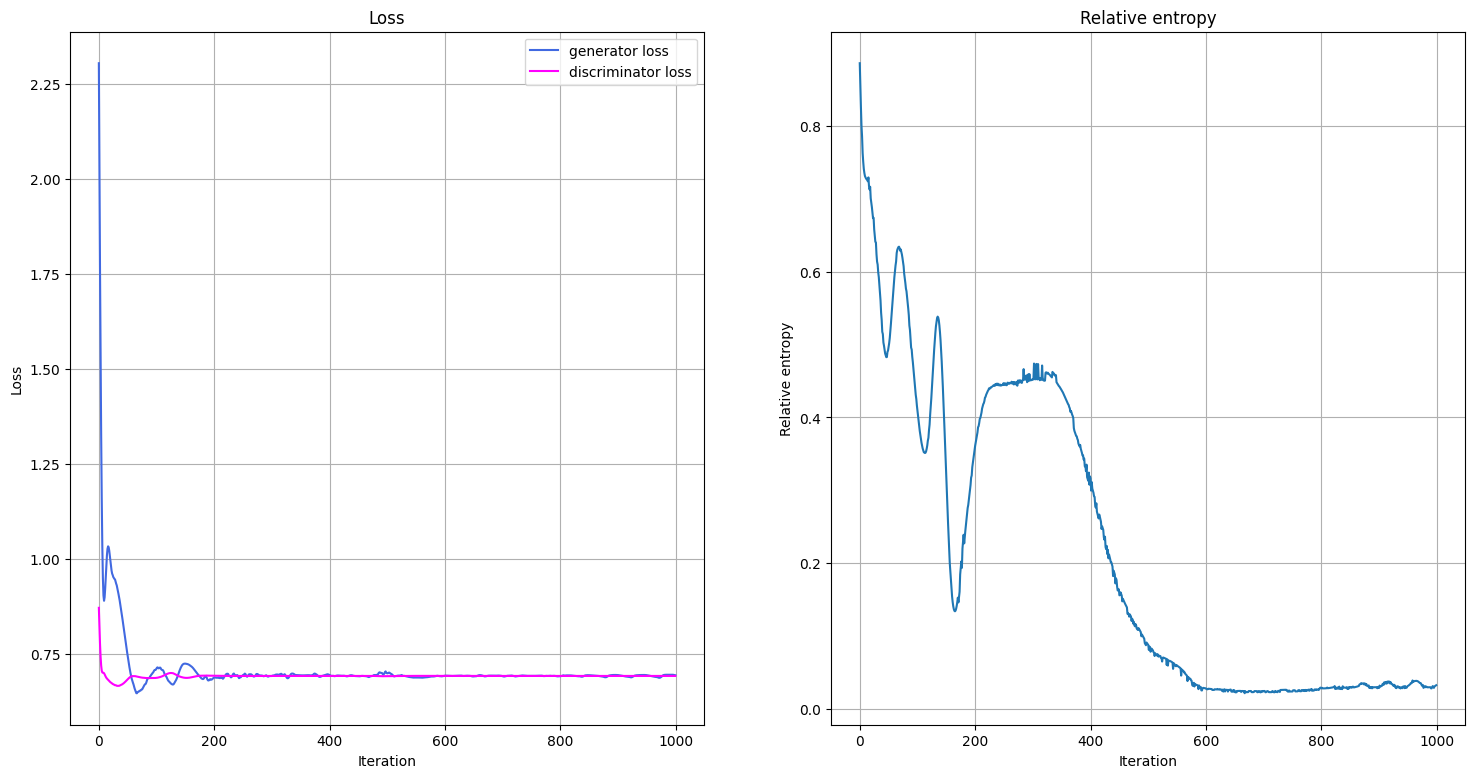

Fit in 237.24 sec


In [58]:
trainer.train(np.array(list(range(16))).reshape(-1,1), log_normal_samples, num_epochs=1000)

In [59]:
trainer.generator_circuit
# print(trainer.generator_ciruit)
parameters = list(trainer.generator.parameters())[0].detach().numpy().tolist()
print(parameters)

[-0.0021387876477092505, 0.1283665895462036, 0.17370785772800446, 0.08162765949964523, 0.0005631549283862114, 0.002794581465423107, 0.0007355919806286693, 0.0006146836094558239, 0.013416020199656487, -0.028053151443600655, 0.07982949912548065, 0.025741789489984512, -0.000240185167058371, 0.00032485160045325756, 0.000949955778196454, 0.0007365817436948419, 0.014096973463892937, 0.14025181531906128, 0.07736445218324661, 0.009249100461602211, 0.0023296144790947437, -0.003587891813367605, -0.0036003815475851297, -0.0015411628410220146, -0.012914340943098068, -0.0718991607427597, -0.3161362409591675, -0.6533833146095276, -0.005461371969431639, -0.0005411417805589736, 0.001869021449238062, -0.0015468241181224585]


In [60]:
qc = trainer.generator_creator.circuit
theta_list = qc.parameters
# qc.decompose().draw()
qc.assign_parameters(dict(zip(theta_list, parameters)))
uncertainty_model = qc.assign_parameters(dict(zip(theta_list, parameters)))

In [61]:
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.primitives import Sampler

amplitudes = Statevector.from_instruction(uncertainty_model).data
# sampler = Sampler()
# result = sampler.run(uncertainty_model).result()
# results_dict = result.quasi_dists[0]
# amplitudes = [np.sqrt(results_dict[key]) for key in results_dict.keys()]


values = [
    bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)
]

x = np.array(values)
y = np.abs(amplitudes) ** 2

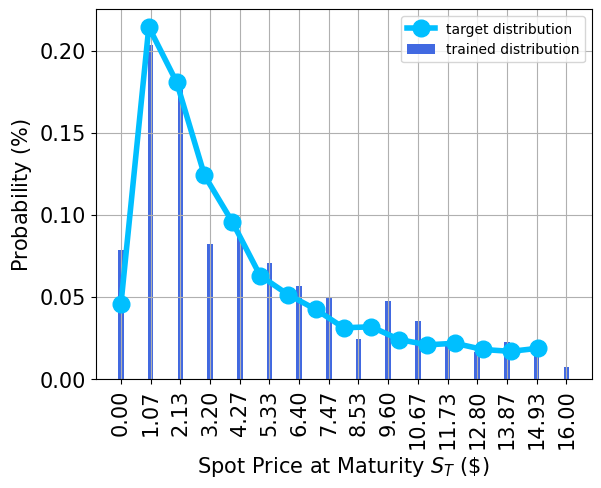

In [62]:
import matplotlib.pyplot as plt

# Plot distributions
plt.bar(x, y, width=0.2, label="trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot(
    log_normal_samples,
    "-o",
    color="deepskyblue",
    label="target distribution",
    linewidth=4,
    markersize=12,
)
plt.legend(loc="best")
plt.show()

We can use a `LinearAmplitudeFunction` to construct functions $F$ that is piece-wise linear of the following operation
$$
F\ket{x}\ket{0} = \sqrt{1-\hat{f}(x)}\ket{x}\ket{0} + \sqrt{\hat{f}(x)}\ket{x}\ket{1}
$$

# Payoff function uploading

In [ ]:
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()